Investigating duplicates
====

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
""" Load data """
from ema import read

meal_info = read.all_meal_info()
meal_info = read.add_timedelta(meal_info)

# Remove early entries
meal_info = meal_info[meal_info["delta"].dt.days >= 1]

In [3]:
""" Find the watch serial number of each participant """
import re

# Open the feasibility file
feasibility_info = read.smartwatch_feasibility()
keep = feasibility_info["smartwatchwilling"] == 1
feasibility_info = feasibility_info[keep]

# Find unique smartwatchid's
sw_ids = list({id_ for id_ in feasibility_info["smarwatchid"].str.upper()})


def sort_key(s):
    # Find all digit groups
    digits = re.findall(r"\d+", s)
    if digits:
        # If there are digits, return a tuple with the non-digit part and the first group of digits as an integer
        return (s.rstrip(digits[0]), int(digits[0]))
    else:
        # If there are no digits, just return the string
        return (s,)


sw_ids = sorted(sw_ids, key=sort_key)


# Create dict of resident ID : smartwatch ID
lookup = dict(
    zip(feasibility_info["residents_id"], feasibility_info["smarwatchid"].str.upper())
)

In [4]:
""" Find which watches had the most duplicates """
import numpy as np
from ema import clean

pids = []
n_duplicates = []

for p_id, slice in meal_info.groupby("p_id"):
    # Count the number of duplicates per participant
    n_duplicates.append(np.sum(clean.duplicates(slice)))

    pids.append(p_id)

# Find the serial number of each participant's watch
dups_per_sw = {id_: [] for id_ in sw_ids}

# Find the number of duplicates per watch
# Iterate over participants and how many duplicates
# Find which watch the participant had
# Append the number of duplicates to the watch
for p_id, n_dup in zip(pids, n_duplicates):
    # Find the watch serial number
    sw_id = lookup[p_id]

    # Append the number of duplicates to the watch
    dups_per_sw[sw_id].append(n_dup)

dups_per_sw = dict(sorted(dups_per_sw.items()))

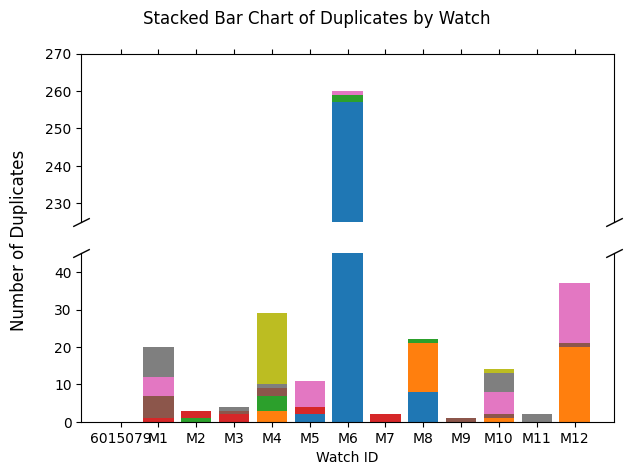

In [5]:
""" Plot a stacked bar chart of which watches had the most duplicates """
import matplotlib.pyplot as plt


def plot_bars(axis):
    max_bars = max(len(duplicates) for duplicates in dups_per_sw.values())
    # Create a list of colors for the bars
    colors = plt.cm.tab10(np.linspace(0, 1, max_bars))

    for i in range(max_bars):
        heights = []
        bottoms = []
        for watch_id in sw_ids:
            if i < len(dups_per_sw[watch_id]):
                # If this watch has this bar, get the height and bottom
                height = dups_per_sw[watch_id][i]
                bottom = sum(dups_per_sw[watch_id][:i])
            else:
                # If this watch doesn't have this bar, the height is 0 and the bottom is the last cumulative sum
                height = 0
                bottom = sum(dups_per_sw[watch_id])

            heights.append(height)
            bottoms.append(bottom)

        axis.bar(sw_ids, heights, bottom=bottoms, color=colors[i])


fig, axes = plt.subplots(2, 1, sharex=True)

plot_bars(axes[0])
plot_bars(axes[1])

axes[0].set_ylim(225, 270)
axes[1].set_ylim(0, 45)

axes[0].spines.bottom.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop=False)  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()

# Plot the slanted lines
d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)

axes[1].set_xlabel("Watch ID")
fig.supylabel("Number of Duplicates")
fig.suptitle("Stacked Bar Chart of Duplicates by Watch")
fig.tight_layout()